# Метанпромбанк — Анализ оттока клиентов

## Описание проекта

Добро пожаловать в один из лучших банков страны «Метанпромбанк»! Наш банк в срочном порядке ищет аналитиков с уверенным владением «Python». Вашей главной задачей станет анализ оттока клиентов. Анализ покажет, как клиенты пользуются нашими услугами, а так же поможет нам составить портрет клиентов, которые склонны уходить из банка.
«Метанпромбанк» — деньги не пахнут!

![jupyter](https://img.rudalle.ru/images/dd/6f/21/dd6f21159b5540b1b13d52fc31fc7fe8_00000.jpg)

### Задача

Проанализируйте клиентов регионального банка и выделите портрет клиентов, которые склонны уходить из банка.

- Проведите исследовательский анализ данных,
- Выделите портреты клиентов, которые склонны уходить из банка,
- Сформулируйте и проверьте статистические гипотезы.

    
    - Проверьте гипотезу различия дохода между теми клиентами, которые ушли и которые остались;
    
    - Гипотезу различия среднего возраста между клиентами, которые ушли и теми, которые остались.

### Описание данных


Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- **`userid`** — идентификатор пользователя,
- **`score`** — баллы кредитного скоринга,
- **`City`** — город,
- **`Gender`** — пол,
- **`Age`** — возраст,
- **`Objects`** — количество объектов в собственности,
- **`Balance`** — баланс на счёте,
- **`Products`** — количество продуктов, которыми пользуется клиент,
- **`CreditCard`** — есть ли кредитная карта,
- **`Loyalty`** — активный клиент,
- **`estimated_salary`** — заработная плата клиента,
- **`Churn`** — ушёл или нет.

## Загрузка и предобработка данных
- Исследуем пропущенные значения;
- Исследуем дубликаты;
- Исследуем соответствие типов;
- Проверим корректность наименований колонок;

In [1]:
import pandas as pd
import scipy.stats as stats
from scipy import stats as st
import math as mth
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
%autosave 30

Autosaving every 30 seconds


In [2]:
df = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
def first_look(df):
    print('---------------------------Первые 5 строк----------------------------')
    display(df.head())
    print(' ')
    print(' ')
    print('--------------Общая информация--------------')
    print(' ')
    print(df.info())
    print(' ')
    print('-------------Пропуски------------- ')
    print(' ')
    count=0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков')
            count = +1
    if count == 0:
        print(' ')
        print('Пропусков НЕТ')
    print(' ')
    print('-------------Дубликаты------------ ')
    print(' ')
    if df.duplicated().sum() > 0:
        print(' ')
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    print(' ')  

In [4]:
first_look(df)

---------------------------Первые 5 строк----------------------------


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
 
-------------Пропуски------------- 
 
Balance  -  3617 пропусков
 
-------------Дубликаты------------ 
 
Дублика

**За исключением "balance" все данные корректны.**

In [5]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

# переименуем столбец 'userid'
df = df.rename({'userid':'user_id'}, axis=1)
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

In [6]:
# временно присвоим категориальным данным числовые значения
df['gender'] = df['gender'].replace('Ж','0').replace('М','1').astype('int')
df['city'] = (df['city'].replace('Ростов Великий','1')
              .replace('Рыбинск','2').replace('Ярославль','3').astype('int'))

In [7]:
# посмотрим на распределения значений в разрезе незаполненных 'balance' 
balance_nan = df.query('balance != balance')
balance_nan.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,3617.0,1.573469e+07,71947.494611,15608442.00,15672255.00,15736083.00,15796286.00,15858100.00
score,3617.0,6.494529e+02,96.158798,350.00,583.00,651.00,717.00,850.00
city,3617.0,2.668510e+00,0.470814,2.00,2.00,3.00,3.00,3.00
gender,3617.0,5.427150e-01,0.498241,0.00,0.00,1.00,1.00,1.00
age,3617.0,3.843489e+01,10.492002,18.00,31.00,37.00,43.00,88.00
objects,3617.0,5.071330e+00,2.860781,0.00,3.00,5.00,7.00,10.00
balance,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,3617.0,1.784628e+00,0.496455,1.00,1.00,2.00,2.00,4.00
creditcard,3617.0,7.166160e-01,0.450704,0.00,0.00,1.00,1.00,1.00
loyalty,3617.0,5.178325e-01,0.499751,0.00,0.00,1.00,1.00,1.00


Видим, что в Ростове Великом нет пропусков в балансе на счёте

**Посмотрим на распределение 'balance' в Рыбинске и Ярославле, для выявления способа заполнения пропусков**

In [8]:
# вернём категориальные значения обратно
df['city'] = (df['city'].replace(1,'Ростов Великий')
              .replace(2,'Рыбинск').replace(3,'Ярославль'))

In [9]:
# соотношение клиентов по городам
df['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

In [10]:
# проверим кол-во заполненных данных о балансе на счёте по городам
df.groupby('city').agg({'balance':'count'})

,balance
city,
Ростов Великий,2509
Рыбинск,1278
Ярославль,2596


В Рыбинске и Ярославле заполнена только половина данных о балансе.

In [11]:
# посмотрим на распределения в Рыбинске
ribinsk = df.query('city == "Рыбинск"')
ribinsk.describe()

,user_id,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,2.477000e+03,2477.000000,2477.000000,2477.000000,2477.000000,1278.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000
mean,1.573465e+07,651.333872,0.560355,38.890997,5.032297,119814.985923,1.539362,0.694792,0.529673,99440.572281,0.166734
std,7.176554e+04,94.365051,0.496444,10.446119,2.856660,32342.692736,0.564646,0.460588,0.499220,57103.678091,0.372813
min,1.560844e+07,350.000000,0.000000,18.000000,0.000000,12459.190000,1.000000,0.000000,0.000000,417.410000,0.000000
25%,1.567228e+07,587.000000,0.000000,32.000000,3.000000,98066.692500,1.000000,0.000000,0.000000,50267.690000,0.000000
50%,1.573453e+07,651.000000,1.000000,37.000000,5.000000,119726.450000,2.000000,1.000000,1.000000,99984.860000,0.000000
75%,1.579649e+07,715.000000,1.000000,44.000000,8.000000,140342.130000,2.000000,1.000000,1.000000,147278.430000,0.000000
max,1.585843e+07,850.000000,1.000000,88.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


<AxesSubplot:>

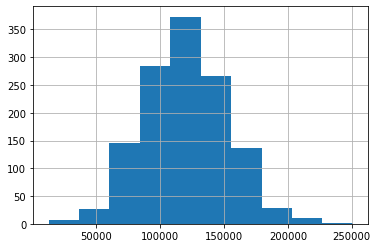

In [12]:
# построим гистограмму распределения баланса га счёте для Рыбинска
ribinsk['balance'].hist()

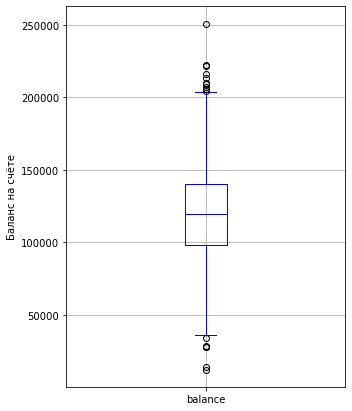

In [13]:
# посмотрим на выбросы в балансе на счёте в Рыбинске
plt.figure(figsize=(5,7))
ribinsk.boxplot(column=['balance'], color='blue') 
plt.ylabel('Баланс на счёте')
plt.show()

In [14]:
# посмотрим на распределения в Ярославле
yaroslavl = df.query('city == "Ярославль"')
yaroslavl.describe()

,user_id,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,5.014000e+03,5014.000000,5014.000000,5014.000000,5014.000000,2596.000000,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000
mean,1.573339e+07,649.668329,0.549063,38.511767,5.004587,119927.765597,1.530913,0.706621,0.516753,99899.180814,0.161548
std,7.137584e+04,97.016799,0.497637,10.469459,2.888475,31732.792620,0.570347,0.455356,0.499769,57336.289016,0.368072
min,1.560845e+07,350.000000,0.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,90.070000,0.000000
25%,1.567134e+07,582.000000,0.000000,31.000000,2.000000,98440.985000,1.000000,0.000000,0.000000,51399.190000,0.000000
50%,1.573351e+07,653.000000,1.000000,37.000000,5.000000,120135.155000,1.000000,1.000000,1.000000,99132.310000,0.000000
75%,1.579491e+07,717.000000,1.000000,43.000000,7.000000,141143.112500,2.000000,1.000000,1.000000,149295.360000,0.000000
max,1.585840e+07,850.000000,1.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199929.170000,1.000000


<AxesSubplot:>

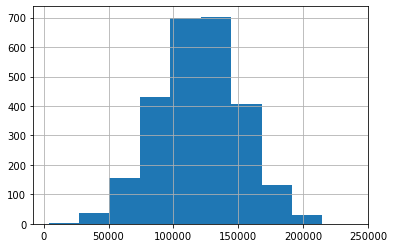

In [15]:
# построим гистограмму распределения баланса га счёте для Ярославля
yaroslavl['balance'].hist()

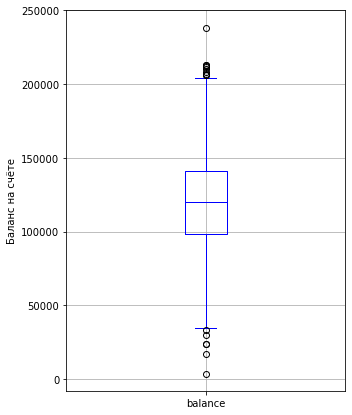

In [16]:
# посмотрим на выбросы в балансе на счёте в Яровлавле
plt.figure(figsize=(5,7))
yaroslavl.boxplot(column=['balance'], color='blue') 
plt.ylabel('Баланс на счёте')
plt.show()

<AxesSubplot:xlabel='city', ylabel='balance'>

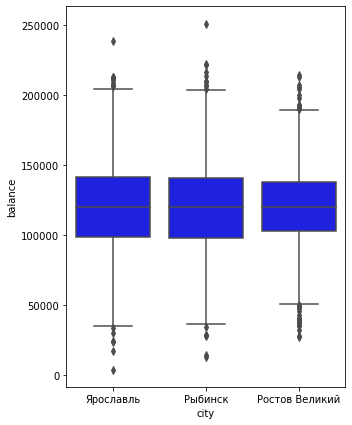

In [17]:
# посмотрим на выбросы в 3 городах
plt.figure(figsize =(5,7))
sns.boxplot (data=df, x='city', y='balance', color='blue')

**Есть выбросы, но и без них разброс слишком большой, чтобы заполнять пропуски средним или медианой. С учётом того, что пропусков у нас 36%, считаю нужным оставить их для чистоты исследования.**

## Исследовательский анализ данных

- Изучим средние значения и стандартные отклонения;
- Проверим выбросы;
- Посмотрим на средние значения признака "churn";
- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался;
- Построим матрицу корреляций.

### Изучим средние значения

In [18]:
# соотношение клиентов по городам
df['city'].value_counts(True)

Ярославль         0.5014
Ростов Великий    0.2509
Рыбинск           0.2477
Name: city, dtype: float64

In [19]:
# посмотрим на средние значения и стандартные отклонения
df.describe()

,user_id,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,0.545700,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,0.497932,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,0.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,0.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,1.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,1.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


![jupyter](https://investvlg.ru/800/600/https/p2.zoon.ru/b/9/58e25dd940c08885708ceda2_5d563d8ec3280.jpg)

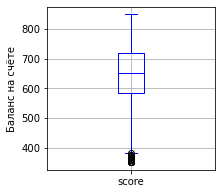

In [20]:
plt.figure(figsize =(3,3))
df.boxplot(column=['score'], color ='blue') 
plt.ylabel('Баланс на счёте')
plt.show()

-  Средний балл кредитного скоринга - **650** и общее распределение значения "score" говорит о хорошей возможности большенства клиентов получить кредит;
- Разделение М/Ж - **55%/45%**;
- Средний возраст - **39 лет**;
- В среднем у клиентов по **5** объектов;
- Средняя сумма на балансе - **120.000**;
- Активных клиентов немного больше - **51,5%**;
- Средняя заработная плата - **100.000**;
- Ушедших клиентов примерно **20%**.


### Проверим выбросы

посмотрим на выбросы в разрезе оттока
for col in df:
    plt.figure(figsize =(3,3))
    sns.boxplot(data=df, x='churn', y=col, palette ='Blues')

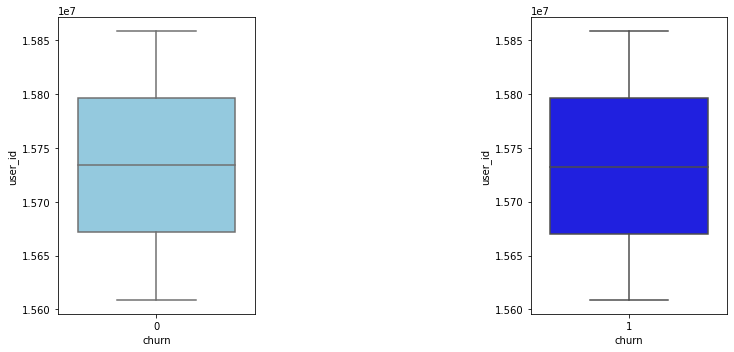

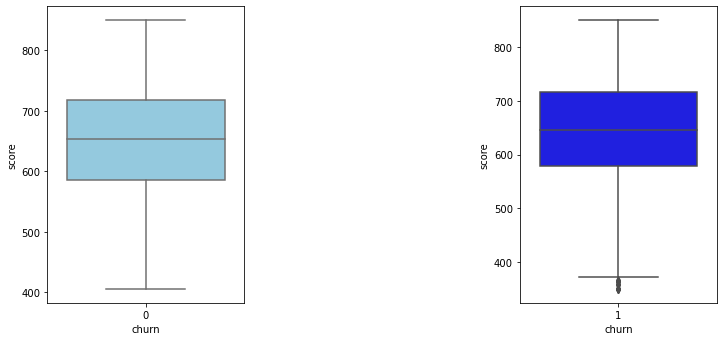

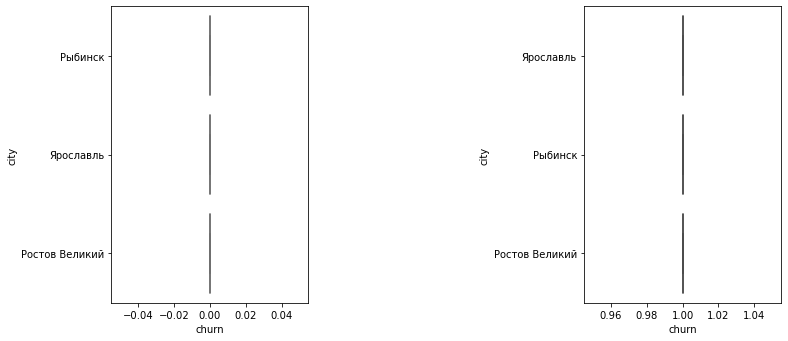

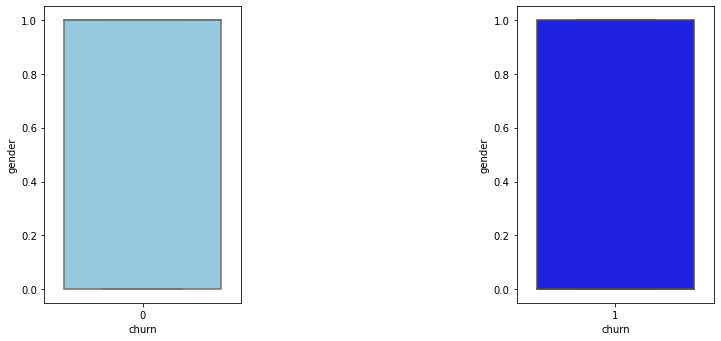

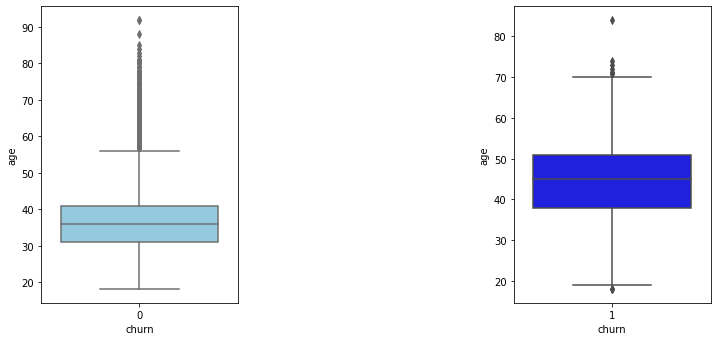

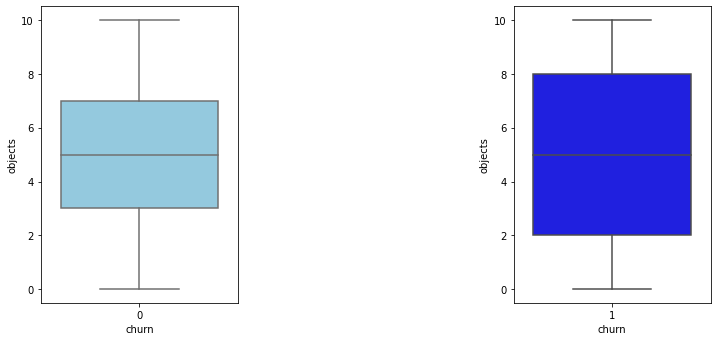

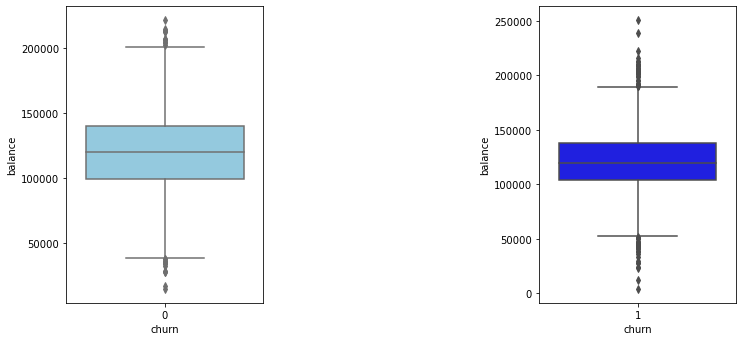

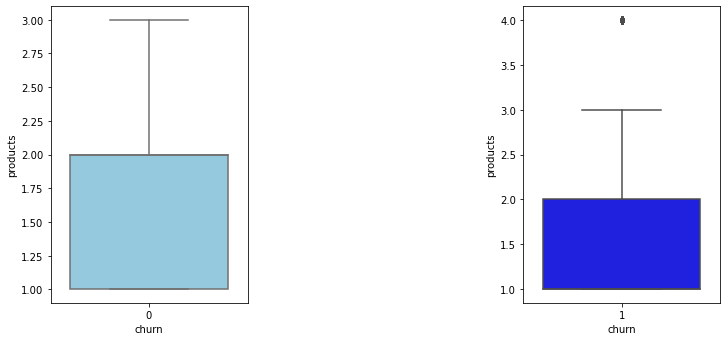

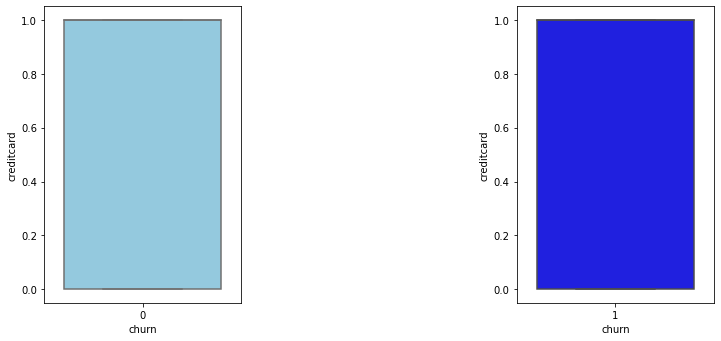

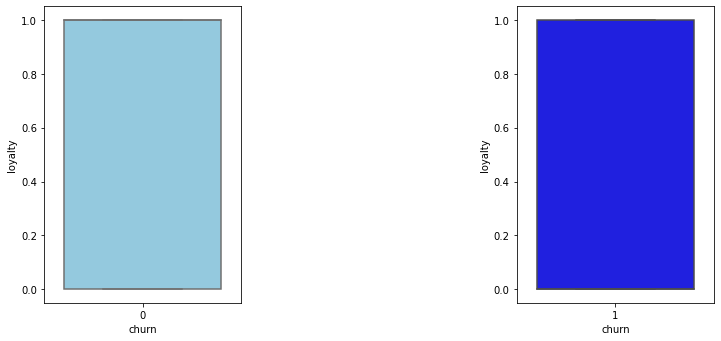

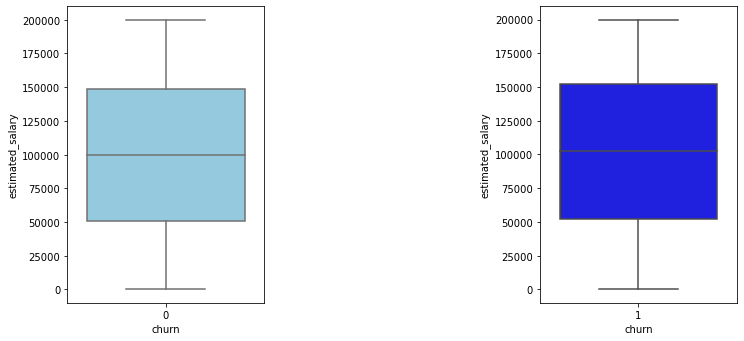

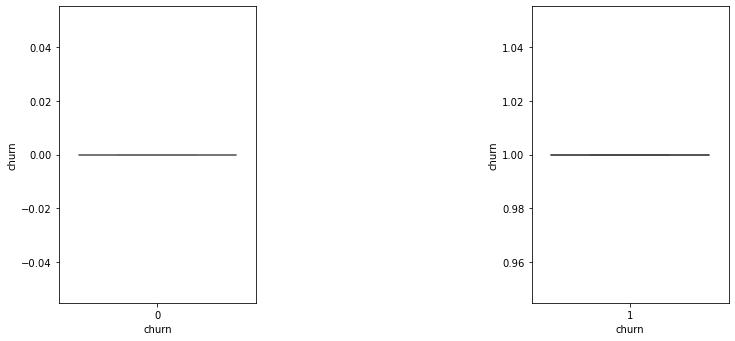

In [21]:
# посмотрим на выбросы в разрезе оттока
churn_0 = df.query('churn == 0') 
churn_1 = df.query('churn == 1')

for col in df:
    plt.figure(figsize =(12,12))
    ax1 = plt.subplot(2,3,1)
    ax1 = sns.boxplot(data=churn_0, x='churn', y=col, color = 'Skyblue')
    
    ax2 = plt.subplot(2,3,3)
    ax2 = sns.boxplot(data=churn_1, x='churn', y=col, color ='blue')
    plt.show()

**Выделяются следующие выбросы:**

- баллы скоринга меньше 390 у ушедших;
- возраст больше 57 лет у оставшихся;
- возраст меньше 19 лет и больше 70 лет у ушедших;
- баланс на счёте меньше 45.000 и больше 200.000 у оставшихся;
- баланс на счёте меньше 51.000 и больше 190.000 у ушедших;
- количество продуктов равное 4 у ушедших.

### Посмотрим на средние значения признака "churn"

In [22]:
df['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [23]:
# вновь присвоим городам числовые значения
df['city'] = (df['city'].replace('Ростов Великий','1')
              .replace('Рыбинск','2').replace('Ярославль','3').astype('int'))

churn_0 = df.query('churn == 0') 
churn_1 = df.query('churn == 1')

**Проверим уровень оттока по городам**

In [24]:
df.query('city == 1')['churn'].value_counts(normalize=True)

0    0.675568
1    0.324432
Name: churn, dtype: float64

In [25]:
df.query('city == 2')['churn'].value_counts(normalize=True)

0    0.833266
1    0.166734
Name: churn, dtype: float64

In [26]:
df.query('city == 3')['churn'].value_counts(normalize=True)

0    0.838452
1    0.161548
Name: churn, dtype: float64

**Уровень оттока в Ростове Великом в 2 раза выше чем в других городах 32% против 16%.**

In [27]:
# посмотрим на средние оставшихся
churn_0.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
user_id,7963.0,15733903.88,71744.23,15608437.00,15671554.50,15734279.00,15796088.50,15858426.00
score,7963.0,651.85,95.65,405.00,585.00,653.00,718.00,850.00
city,7963.0,2.32,0.80,1.00,2.00,3.00,3.00,3.00
gender,7963.0,0.57,0.49,0.00,0.00,1.00,1.00,1.00
age,7963.0,37.41,10.13,18.00,31.00,36.00,41.00,92.00
objects,7963.0,5.03,2.88,0.00,3.00,5.00,7.00,10.00
balance,4846.0,119535.86,29944.93,14262.80,99118.23,119791.22,139747.40,221532.80
products,7963.0,1.54,0.51,1.00,1.00,2.00,2.00,3.00
creditcard,7963.0,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,7963.0,0.55,0.50,0.00,0.00,1.00,1.00,1.00


In [28]:
# посмотрим на средние ушедших
churn_1.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
user_id,2037.0,15732787.96,72692.62,15608442.00,15670096.00,15731699.00,15795828.00,15858392.00
score,2037.0,645.35,100.32,350.00,578.00,646.00,716.00,850.00
city,2037.0,2.00,0.89,1.00,1.00,2.00,3.00,3.00
gender,2037.0,0.44,0.50,0.00,0.00,0.00,1.00,1.00
age,2037.0,44.84,9.76,18.00,38.00,45.00,51.00,84.00
objects,2037.0,4.93,2.94,0.00,2.00,5.00,8.00,10.00
balance,1537.0,120746.97,30555.19,3768.69,103700.69,119948.09,137986.58,250898.09
products,2037.0,1.48,0.80,1.00,1.00,1.00,2.00,4.00
creditcard,2037.0,0.70,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,2037.0,0.36,0.48,0.00,0.00,0.00,1.00,1.00


In [29]:
df_churn = df.groupby('churn').mean().round(2)
df_churn.T

churn,0,1
user_id,15733903.88,15732787.96
score,651.85,645.35
city,2.32,2.00
gender,0.57,0.44
age,37.41,44.84
objects,5.03,4.93
balance,119535.86,120746.97
products,1.54,1.48
creditcard,0.71,0.70
loyalty,0.55,0.36


**Средние заметно отличаются в следующих признаках:**

- гендер - среди ушедших преобладают женщины - 44%;
- возраст - 37 лет у оставшихся и 44 лет у ушедших;
- большая разница в активности клиентов.

In [30]:
churn_0.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

In [31]:
# оставим интересующие нас признаки
churn_0 = churn_0[['score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty']]
churn_1 = churn_1[['score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty']]

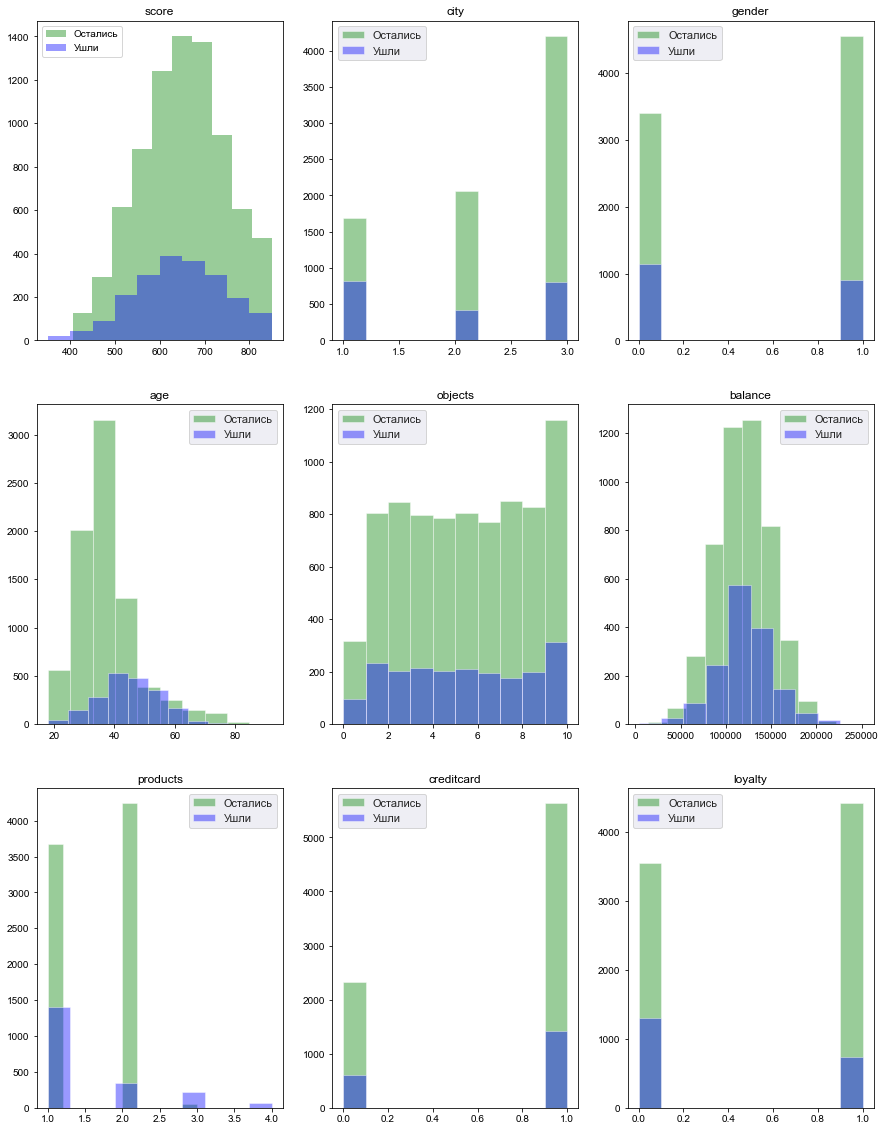

In [32]:
# построим графики распределение признаков в разрезе "churn"
fig, ax = plt.subplots(3,3, figsize = (15,20))
ax = ax.ravel()

for i in range(len(churn_0.columns)):
    col = churn_0.columns[i]
    (sns.distplot(churn_0[col],ax=ax[i],label='Остались',axlabel = False,color='green'
                  ,kde=False,bins=10))      
    sns.distplot(churn_1[col],ax=ax[i],label='Ушли',axlabel = False,color='blue',kde=False,bins=10)
    ax[i].legend()
    ax[i].set_title(col)
    sns.set()
    
plt.show()

**По графикам видно, что:**

- уходят в основном клиенты имеющие хорошие скоринговые баллы;
- женщин уходит немного больше;
- ушедшим в основном за 40 лет;
- имеют более 1 объекта в собственности;
- на балансе счёта у них 100.000 - 150.000;
- пользуются в основном 1 продуктом банка;
- имеют кредитную карту банка;
- значительно менее активны.

### Построим матрицу корреляций и визуализируем её

In [33]:
# воспользуемся one-hot кодировкой для корректного построения матрицы корреляций
df_corr = df.copy()
df_corr = pd.get_dummies(df_corr, columns=['city'])
df_corr

,user_id,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_1,city_2,city_3
0,15677338,619,0,42,2,NaN,1,1,1,101348.88,1,0,0,1
1,15690047,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15662040,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1
3,15744090,699,0,39,1,NaN,2,0,0,93826.63,0,0,0,1
4,15780624,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,1,39,5,NaN,2,1,0,96270.64,0,0,0,1
9996,15612628,516,1,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,15627268,709,0,36,7,NaN,1,0,1,42085.58,1,0,0,1
9998,15725091,772,1,42,3,75075.31,2,1,0,92888.52,1,1,0,0


In [34]:
# построим матрицу корреляций
df_corr = df_corr.corr()
df_corr

,user_id,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_1,city_2,city_3
user_id,1.000000,0.005308,-0.002641,0.009497,-0.014883,-0.008690,0.016972,-0.014025,0.001665,0.015271,-0.006248,-0.003097,0.007800,-0.004049
score,0.005308,1.000000,-0.002857,-0.003965,0.000842,-0.004744,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.008928
gender,-0.002641,-0.002857,1.000000,-0.027544,0.014733,0.025742,-0.021859,0.005766,0.022544,-0.008112,-0.106512,-0.024628,0.016889,0.006772
age,0.009497,-0.003965,-0.027544,1.000000,-0.009997,-0.012822,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.039208
objects,-0.014883,0.000842,0.014733,-0.009997,1.000000,0.005827,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.000567,0.003868,-0.002848
balance,-0.008690,-0.004744,0.025742,-0.012822,0.005827,1.000000,-0.001027,0.006721,-0.020418,-0.001856,0.017208,-0.002604,-0.000208,0.002759
products,0.016972,0.012238,-0.021859,-0.030680,0.013444,-0.001027,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,0.001230
creditcard,-0.014025,-0.005458,0.005766,-0.011721,0.022583,0.006721,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.002467
loyalty,0.001665,0.025651,0.022544,0.085472,-0.028362,-0.020418,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.003317
estimated_salary,0.015271,-0.001384,-0.008112,-0.007201,0.007784,-0.001856,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.003332


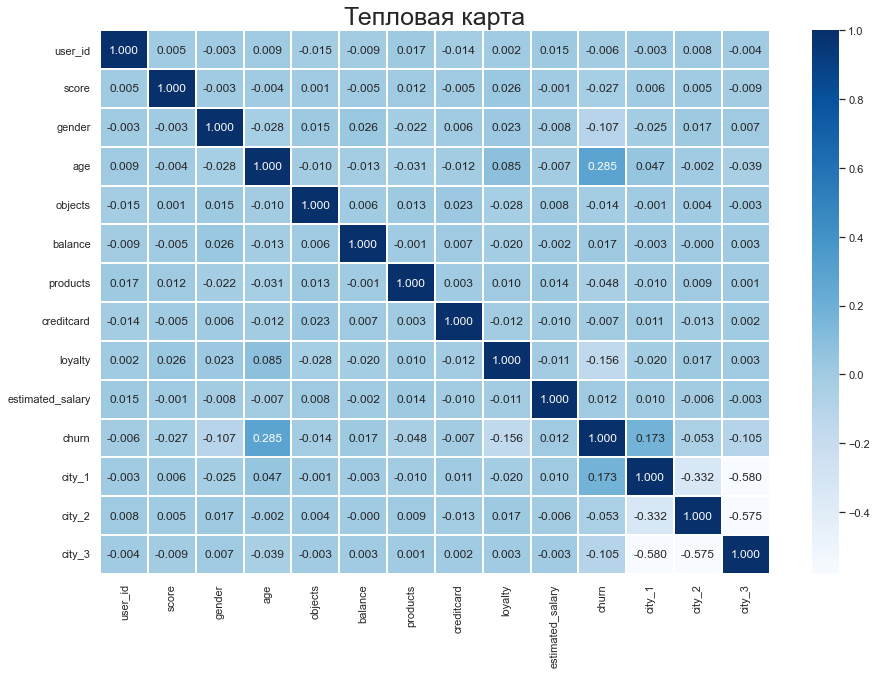

In [35]:
# построим тепловую карту для матрицы корреляций
plt.figure(figsize=(15,10))
sns.heatmap(df_corr,annot=True,fmt='0.3f',linewidths=2, cmap="Blues")
plt.title('Тепловая карта', fontsize=25)
plt.show()

**Наиболее коррелирующие с "churn" признаки:**

- **age** - 28.5%
- **Ростов Великий** - 17.3%
- **loyalty** - 15.6%
- **city** - 15.4%
- **gender** - 10.7%
- **Ярославль** - 10.5%

## Кластеризация клиентов

In [36]:
# заполним пропуски в балансе медианой
df = df.fillna(120000)

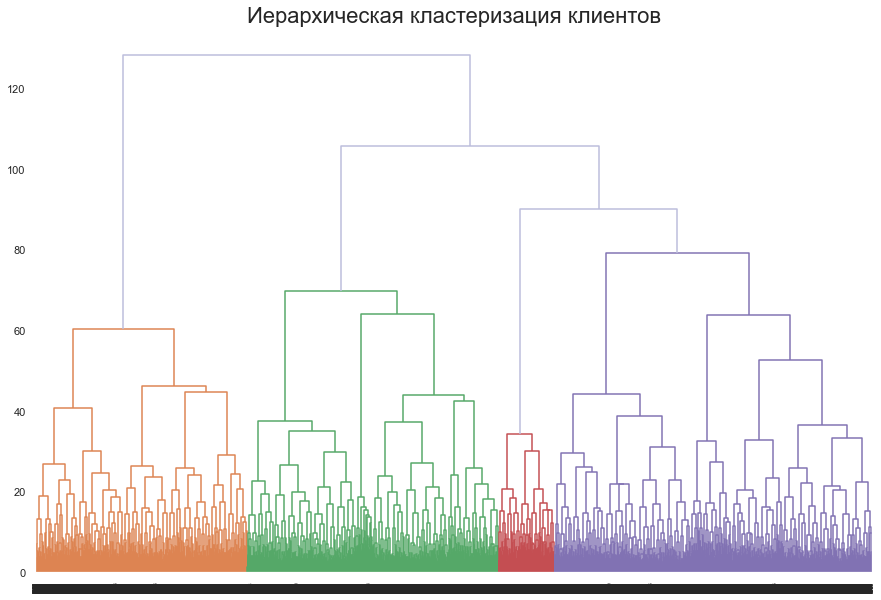

In [37]:
# разделим данные на признаки и целевую переменную
X = df.drop('churn', axis=1)
y = df['churn']

# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward') 

# визуализируем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', above_threshold_color='#bcbddc')
plt.title('Иерархическая кластеризация клиентов', fontsize=22)
plt.show() 

**На основании полученной дендрограммы можно выделить 4 класса, но один совсем небольшой**

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [38]:
# зададим модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=3, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраним метки кластера в поле нашего датасета
df['cluster_km'] = labels

### Посмотрим на средние значения признаков для кластеров. 

In [39]:
# выведем статистику по средним значениям наших признаков по кластеру
clusters_t = df.groupby('cluster_km').agg('mean').round(2)
clusters_t.T

cluster_km,0,1,2
user_id,15733870.02,15732140.50,15735238.06
score,652.95,647.30,651.35
city,2.26,2.23,2.26
gender,0.56,0.53,0.54
age,39.65,38.00,39.11
objects,4.99,5.12,4.91
balance,119609.37,120357.07,119686.49
products,1.54,1.52,1.53
creditcard,1.00,1.00,0.00
loyalty,1.00,0.00,0.52


In [40]:
df['cluster_km'].value_counts()

0    3607
1    3448
2    2945
Name: cluster_km, dtype: int64

**Алгоритм выделил:**

- возраст 38 лет и за 39;
- отсутствие кредитной карты во 2 кластере;
- разделил кластеры по лояльности 100%, 0% и 52%;
- больше всего ушедших в 1 кластере - 27%, меньше всего в 0 - 13%.

### Построим распределения признаков для кластеров

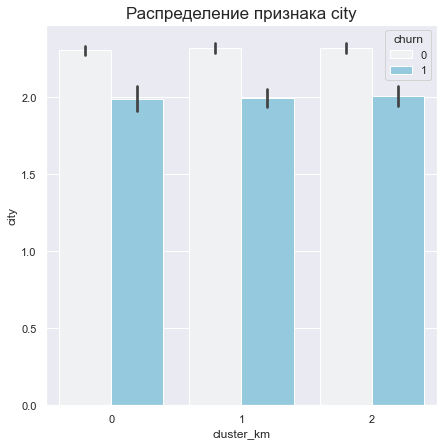

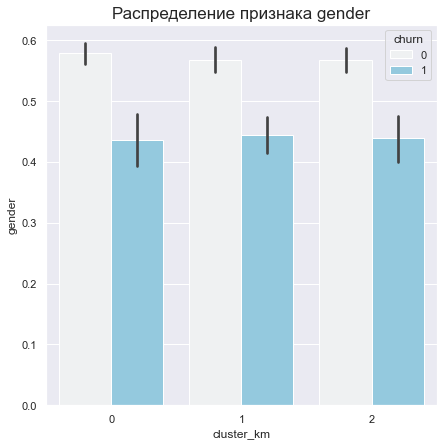

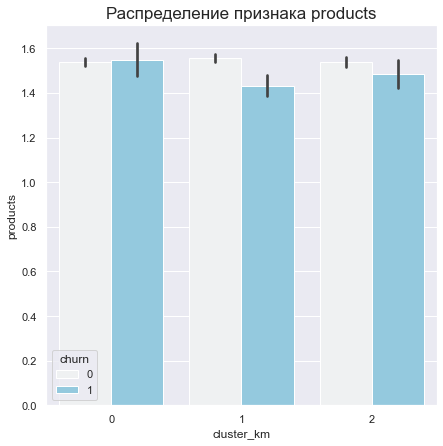

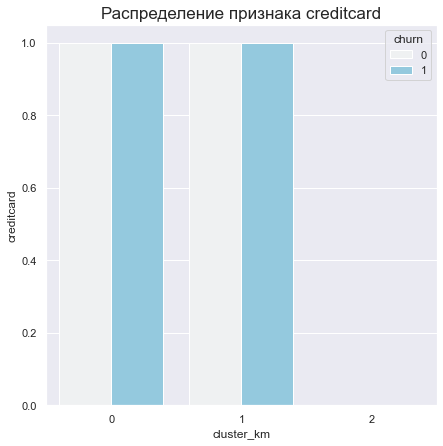

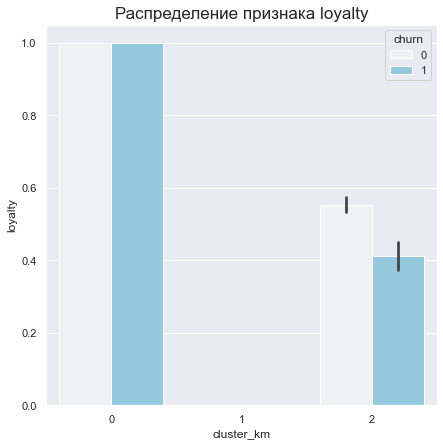

In [41]:
# выделим категориальные признаки
categorical = ['city', 'gender', 'products', 'creditcard', 'loyalty']

for val,col in enumerate(categorical):
    plt.figure(figsize=(7,7))
    sns.barplot(x=df['cluster_km'], y=df[col], hue=df['churn'], color='Skyblue')
    plt.title('Распределение признака '+ str(col), fontsize=17)
    plt.show()

- В 0 кластере одинаково активны и ушедшие и оставшиеся;
- В 1 кластере нет активных клиентов;
- Во 2 кластере разделение активности - ~ 55% оставшихся и ~ 41% ушедших;

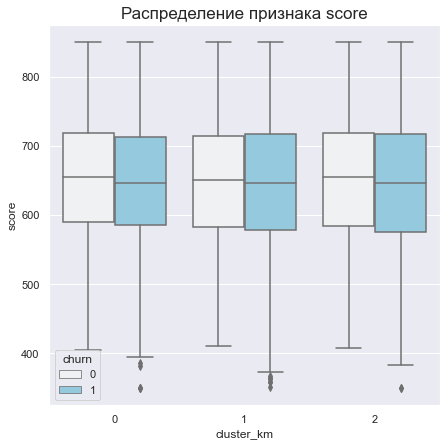

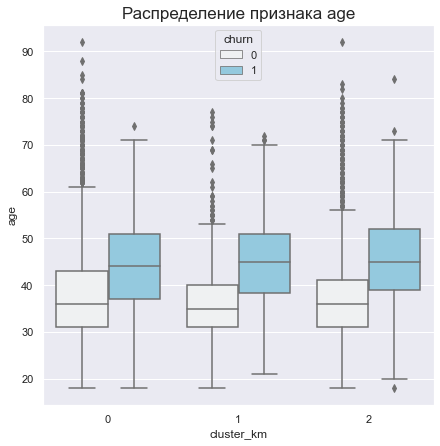

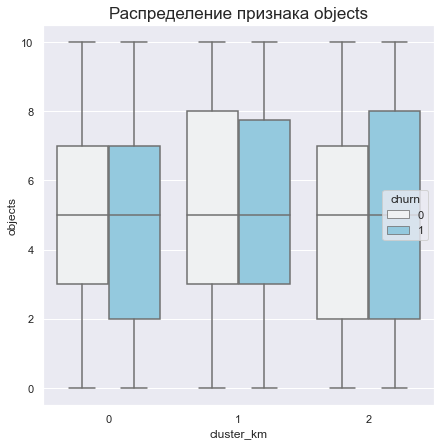

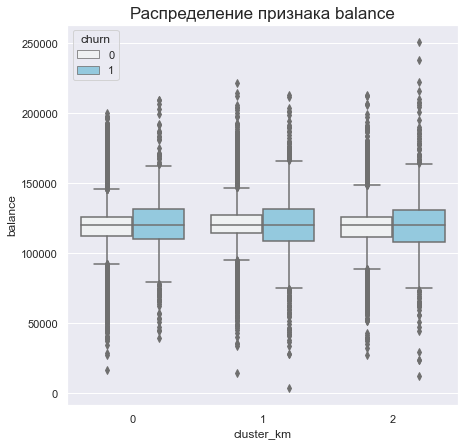

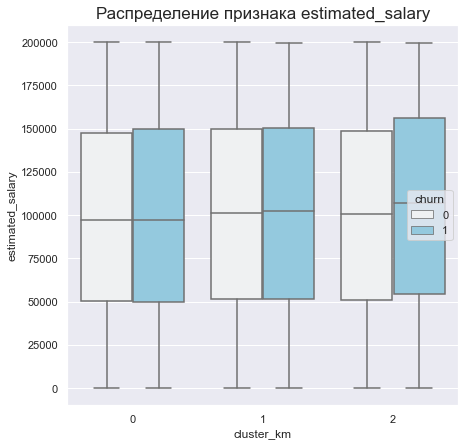

In [42]:
# выделим числовые признаки
numeric = ['score', 'age', 'objects', 'balance', 'estimated_salary']

for val,col in enumerate(numeric):
    plt.figure(figsize=(7,7))
    sns.boxplot(x=df['cluster_km'], y=df[col], hue=df['churn'], color='Skyblue')
    plt.title('Распределение признака '+ str(col), fontsize=17)
    plt.show()

### Для каждого полученного кластера посчитаем долю оттока

In [43]:
# сгруппируем по кластеру и посчитаем кол-во клиентов в каждом и кол-во ушедших
df_cluster =df.groupby('cluster_km').agg({'user_id':'count', 'churn':'sum'})
df_cluster.columns = ['count_users', 'churn_users']

# посчитаем долю оттока
df_cluster['churn_users_perc'] = round(df_cluster['churn_users'] / df_cluster['count_users'] * 100)
df_cluster['churn_perc_total'] = round(df_cluster['churn_users'] / 10000 * 100, 2)
df_cluster.reset_index()
df_cluster.sort_values(by='churn_perc_total', ascending=False)

,count_users,churn_users,churn_users_perc,churn_perc_total
cluster_km,,,,
1,3448,942,27.0,9.42
2,2945,613,21.0,6.13
0,3607,482,13.0,4.82


- 1 место - **0 кластер** - 13% внутренний отток и 4,82% отток по отношению ко всем клиентам;
- 2 место - **2 кластер** - 21% внутренний отток и 6,13% отток по отношению ко всем клиентам;
- 3 место - **1 кластер** - 27% внутренний отток и 9,42% отток по отношению ко всем клиентам;

**Между 0 и 1 классом есть небольшая разница в возрасте и кол-ве обектов в собственности, но главным отличием является активность клиентов.**

## Статистический анализ данных

### Сформулируем и проверим статистические гипотезы:

- **H0** - Доход между клиентами, которые ушли и теми, которые остались **не различается**;
- **H1** - Доход между клиентами, которые ушли и теми, которые остались **различается**.

<AxesSubplot:>

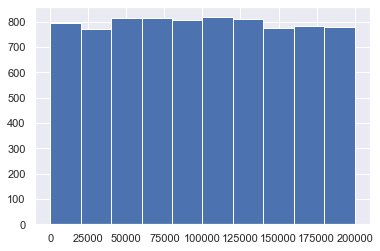

In [44]:
# проверим распределение дохода оставшихся клиентов 
salary_0 = df.query('churn == 0')
salary_0['estimated_salary'].hist()

<AxesSubplot:>

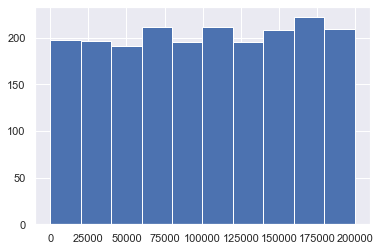

In [45]:
# проверим распределение дохода ушедших клиентов 
salary_1 = df.query('churn == 1')
salary_1['estimated_salary'].hist()

**Для проверки гипотез применим непараметрический тест Уилкоксона-Манна-Уитни, т.к. распределение значений не является нормальным.**

In [46]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(salary_0['estimated_salary'], salary_1['estimated_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.22705150930153783
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


**Большое p-value = 22.7% говорит о том, что доход между клиентами, которые ушли и теми, которые остались не имеет статистически значимых различий.**

- **H0** - Средний возраст между клиентами, которые ушли и теми, которые остались **не различается**;
- **H1** - Средний возраст между клиентами, которые ушли и теми, которые остались **различается**.

In [47]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(salary_0['age'], salary_1['age'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение: 1.2399313093427738e-186
Отвергаем нулевую гипотезу: разница статистически значима


**Тест показывает, что возраст влияет на отток клиентов.**

## Выводы:

**В ходе первичного анализа данных было выявлено:**

- за исключением "balance" все данные в порядке;
- в Ростове Великом нет пропусков в балансе на счёте;
- в Рыбинске и Ярославле заполнена только половина данных о балансе;
- есть выбросы, но и без них разброс слишком большой, чтобы заполнять пропуски средним или медианой. 


**Исследовательский анализ данных показал:**

- в Ярославле проживает - 50% населения, в Ростове Великом и Рыбинске по 25%
- средний балл кредитного скоринга - 650, что говорит о хорошей возможности большенства клиентов получить кредит;
- средний возраст - 39 лет;
- в среднем у клиентов по 5 объектов;
- средняя сумма на балансе - 120.000;
- активных клиентов немного больше - 51,5%;
- средняя заработная плата - 100.000;
- ушедших клиентов примерно 20%.


**Посмотрев на выбросы в разрезе оттока, выявили, что выделяются следующие выбросы:**

- баллы скоринга меньше 390 у ушедших;
- возраст больше 57 лет у оставшихся;
- возраст меньше 19 лет и больше 70 лет у ушедших;
- баланс на счёте меньше 45.000 и больше 200.000 у оставшихся;
- баланс на счёте меньше 51.000 и больше 190.000 у ушедших;
- количество продуктов равное 4 у ушедших.
- **Уровень оттока в Ростове Великом в 2 раза выше чем в других городах 32% против 16%.!!!**

**Средние заметно отличаются в следующих признаках:**

- гендер - среди ушедших преобладают женщины - 44%;
- возраст - 37 лет у оставшихся и 44 лет у ушедших;
- большая разница в активности клиентов.



**По графикам распределения признаков в разрезе "churn" видно:**

- уходят в основном клиенты имеющие хорошие скоринговые баллы;
- женщин уходит немного больше;
- ушедшим в основном за 40 лет;
- ушедшие имеют более 1 объекта в собственности;
- на балансе счёта у них 100.000 - 150.000;
- пользуются в основном 1 продуктом банка;
- имеют кредитную карту банка;
- ушедшие значительно менее активны.

**По тепловой карте видно наиболее коррелирующие с "churn" признаки:**

- age - 28.5%;
- loyalty - 15.6%;
- gender - 10.7%.

На основании полученной дендрограммы можно выделить 4 класса, но один совсем небольшой, поэтому задали модель k_means с 3 кластерами. Алгоритм выделил:

- возраст 38 лет и за 39;
- отсутствие кредитной карты во 2 кластере;
- разделил кластеры по лояльности 100%, 0% и 52%;
- больше всего ушедших в 1 кластере - 27%, меньше всего в 0 - 13%.
- в 0 кластере одинаково активны и ушедшие и оставшиеся;
- в 1 кластере нет активных клиентов;
- во 2 кластере разделение активности - ~ 55% оставшихся и ~ 41% ушедших;

**Доля оттока распределила кластеры по местам:**

- 1 место - 0 кластер - 13% внутренний отток и 4,82% отток по отношению ко всем клиентам;
- 2 место - 2 кластер - 21% внутренний отток и 6,13% отток по отношению ко всем клиентам;
- 3 место - 1 кластер - 27% внутренний отток и 9,42% отток по отношению ко всем клиентам;

Между 0 и 1 классом есть небольшая разница в возрасте и кол-ве объектов в собственности, но главным отличием является активность клиентов.

**Проверка двух гипотез показала:**

- доход между клиентами, которые ушли и теми, которые остались не имеет статистически значимых различий;

- возраст влияет на отток клиентов.



## Рекомендации:

**Приоритизировать работу с 2мя возрастными группами до 30 и после 40 лет**

- **Льготные и бонусные программы для студентов, молодожёнов и молодых специалистов,такие как:**

    - кредит с отсрочкой платежа и беспроцентным периодом,
    - кредиты на отдых,
    - автокредит,
    - ипотека.
    
- **Льготные и бонусные программы для специалистов со стажем от 10 лет, основных направлений экономики региона,такие как:** 
    
    - приборостроение, машиностроение, производство строительных материалов и энергетика для Ростова Великого;
    - двигателестроение, судостроение, энергетическое машиностроение для Рыбинска;
    - машиностроение, химпроизводство и энергетика в Ярославле.
    
- **Льготные и бонусные программы для пенсионеров**

**Развивать активность клиентов проводя рекламные акции**

**Подробнее исследовать причину оттока женской части клиентов банка и большой отток клиентов в Ростове Великом**
       